#### Code Organisation
1. Import libraries
2. Load dataset
3. Data analysis and observations
4. Data preprocessing based on observations

In [142]:
#%pip install keras
#%pip install tensorflow
#%pip install seaborn

In [143]:
# setup, load dataset and imports
# reading image fails with opencv, using Pillow

import os
import pandas as pd
import numpy as np
from PIL import Image
import collections
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

seed=1234

IMAGE = 'image'
EMOTION = 'emotion'
DATASET = '../facial_expressions/'
images_path = DATASET + 'images'
csv_path = DATASET + '/data/legend.csv'

In [144]:
# read from file
legend = pd.read_csv(csv_path)

In [145]:
# data analysis and observations

print(f'Initial data classes: {legend[EMOTION].unique()}')
legend[EMOTION] = legend[EMOTION].str.upper()
print(f'final classes after equalising: {legend[EMOTION].unique()}')

X_an = []
shapes = set()

mins = []
maxs = []
shapes = []
i = 0

for _, row in legend.iterrows():
    image_file = row[IMAGE]
    img_path = os.path.join(images_path, image_file)
    
    with Image.open(img_path) as img:
        img_array = np.array(img)
        mins.append(img_array.min())
        maxs.append(img_array.max())
        i+=1
        shapes.append(img_array.shape)


print(len(shapes), shapes)

#plt.hist(mins)
#plt.hist(maxs)
#plt.hist(shapes)


Initial data classes: ['anger' 'surprise' 'disgust' 'fear' 'neutral' 'happiness' 'sadness'
 'contempt' 'NEUTRAL' 'SADNESS' 'DISGUST' 'FEAR' 'SURPRISE' 'ANGER'
 'HAPPINESS']
final classes after equalising: ['ANGER' 'SURPRISE' 'DISGUST' 'FEAR' 'NEUTRAL' 'HAPPINESS' 'SADNESS'
 'CONTEMPT']
13690 [(536, 347, 3), (536, 355, 3), (536, 355, 3), (536, 356, 3), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350), (350, 350)

In [146]:
# data loading

# 1. data is being grayscaled
# 2. resized to (150,150) before loading
# 3. normalisation to be done for each model differently, might need to move resizing as well

# convert classes to 7
legend[EMOTION] = legend[EMOTION].str.upper()
print(f'final classes after equalising: {legend[EMOTION].unique()}')

# Create class map (unique class labels mapped to indices)
classes = legend[EMOTION].unique()
classMap = {i: class_name for i, class_name in enumerate(classes)}


# Add numeric labels to the dataframe
class_to_index = {class_name: i for i, class_name in enumerate(classes)}
legend['class_index'] = legend[EMOTION].map(class_to_index)


X = []
y = []


for _, row in legend.iterrows():
    image_file = row[IMAGE]
    class_index = row['class_index']
    
    img_path = os.path.join(images_path, image_file)
    
    with Image.open(img_path) as img:
        # convert to grayscale
        img = img.convert('L')

        # resize 
        img = img.resize((48,48), Image.Resampling.BOX)
        img_array = np.array(img)
        X.append(img_array)
        y.append(class_index)
            


# int or float?
X = np.array(X)
y = np.array(y)
X = np.expand_dims(X, axis=-1)



print(f"ClassMap: {classMap}")


final classes after equalising: ['ANGER' 'SURPRISE' 'DISGUST' 'FEAR' 'NEUTRAL' 'HAPPINESS' 'SADNESS'
 'CONTEMPT']
ClassMap: {0: 'ANGER', 1: 'SURPRISE', 2: 'DISGUST', 3: 'FEAR', 4: 'NEUTRAL', 5: 'HAPPINESS', 6: 'SADNESS', 7: 'CONTEMPT'}


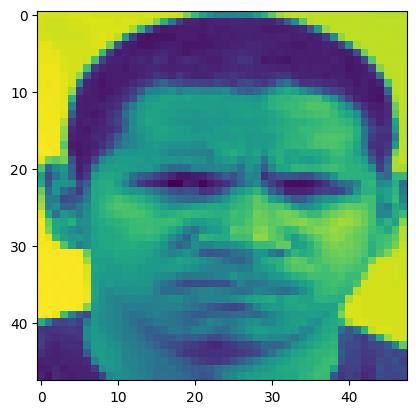

In [159]:
# display images for happiness

#print(X[0])
plt.imshow(X[0])

In [148]:
print(legend.head(1))
for ci in np.unique(y):
    print(f'{ci}, {classMap[ci]}, {X[y==ci].shape[0]}')

  user.id                            image emotion  class_index
0     628  facial-expressions_2868588k.jpg   ANGER            0
0, ANGER, 252
1, SURPRISE, 368
2, DISGUST, 208
3, FEAR, 21
4, NEUTRAL, 6868
5, HAPPINESS, 5696
6, SADNESS, 268
7, CONTEMPT, 9


In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,
    test_size=0.25,
    random_state=seed
    #stratify=y  # Preserve class proportions
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 10267
Testing set size: 3423


### CNN approach

In [170]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers
from sklearn.metrics import classification_report

In [178]:
def myConvNet():
    model = keras.Sequential()

    model.add(layers.Conv2D(1, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))

    # model compilation
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

    print(f'{model.summary()}')

    return model

def train_run(X_tr, y_tr, X_te, y_te):
    model = myConvNet()
    model.fit(X_tr, y_tr)

    y_pred = [y.argmax() for y in model.predict(X_te)]
    #print(y_pred)
    tr_cf_matrix = confusion_matrix(y_te, y_pred)

    labels = [classMap[i] for i in range(0,8)]
    sns.heatmap(tr_cf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

    report = classification_report(y_te, y_pred, target_names=[
    'ANGER', 'SURPRISE', 'DISGUST', 'FEAR', 
    'NEUTRAL', 'HAPPINESS', 'SADNESS', 'CONTEMPT'
    ])
    print(report)

In [152]:
model = myConvNet()
model.fit(X_train,y_train)

/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4336 - loss: 2.1011


In [153]:
print(X_train[0].shape, X_train.dtype)

(48, 48, 1) uint8


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: NEUTRAL, True class: NEUTRAL


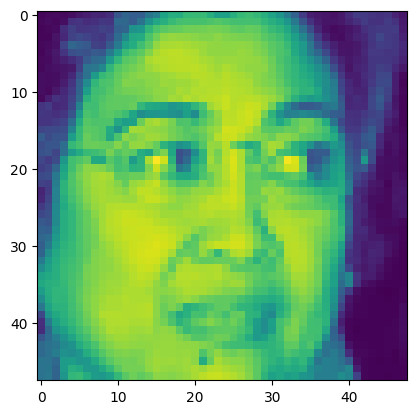

In [154]:
ind = 1065
plt.imshow(X_train[ind])
inp_data = np.expand_dims(X_train[ind], axis=0)
print(f'Predicted class: {classMap[model.predict(inp_data).argmax()]}, True class: {classMap[y_train[ind]]}')

321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

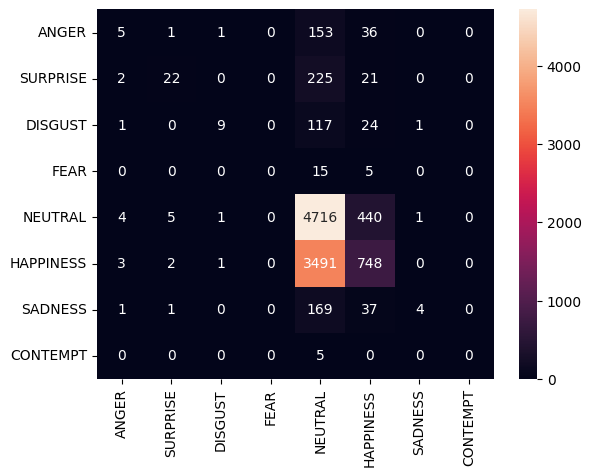

In [155]:
y_pred = [y.argmax() for y in model.predict(X_train)]
#print(y_pred)
tr_cf_matrix = confusion_matrix(y_train, y_pred)

labels = [classMap[i] for i in range(0,8)]
sns.heatmap(tr_cf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4258 - loss: 2.8123
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

       ANGER       0.43      0.02      0.03       196
    SURPRISE       0.34      0.07      0.11       270
     DISGUST       0.67      0.01      0.03       152
        FEAR       0.00      0.00      0.00        20
     NEUTRAL       0.59      0.33      0.42      5167
   HAPPINESS       0.46      0.79      0.58      4245
     SADNESS       0.31      0.02      0.04       212
    CONTEMPT       0.00      0.00      0.00         5

    accuracy                           0.49     10267
   macro avg       0.35      0.15      0.15     10267
weighted avg       0.52      0.49      0.46     10267



/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

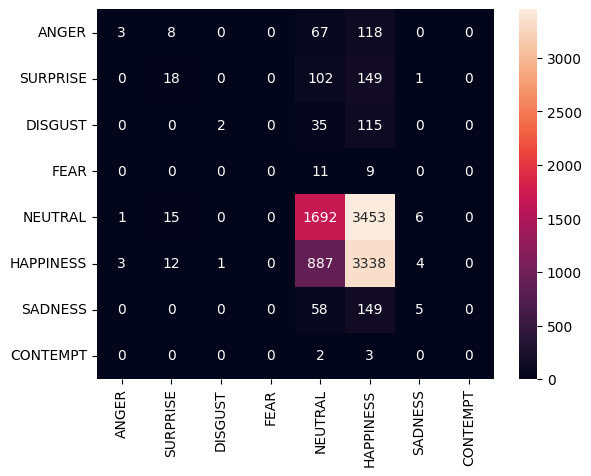

In [176]:
train_run(X_train, y_train, X_train, y_train)

In [156]:
# random undersampling and oversampling
from sklearn.utils import resample
from sklearn.utils import shuffle
from collections import Counter

target_size = 300
majority_c = [4,5]
minority_c = [0,1,2,3,6,7]

X_balanced = []
y_balanced = []

for c in range(0,8):
    X_c = X_train[y_train==c]
    y_c = y_train[y_train==c]
    if c in majority_c:
        # undersample
        X_resampled, y_resampled = resample(
            X_c, y_c, replace=False, n_samples=target_size, random_state=seed
        )
    else:
        # oversample
        X_resampled, y_resampled = resample(
            X_c, y_c, replace=True, n_samples=target_size, random_state=seed
        )

    # Append resampled data
    X_balanced.append(X_resampled)
    y_balanced.append(y_resampled)

# Combine and shuffle balanced dataset
X_balanced = np.concatenate(X_balanced, axis=0)
y_balanced = np.concatenate(y_balanced, axis=0)
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=seed)

/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2155 - loss: 4.1427
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

       ANGER       0.33      0.25      0.29       300
    SURPRISE       0.35      0.35      0.35       300
     DISGUST       0.46      0.29      0.36       300
        FEAR       0.73      0.69      0.71       300
     NEUTRAL       0.21      0.46      0.29       300
   HAPPINESS       0.20      0.17      0.18       300
     SADNESS       0.41      0.23      0.30       300
    CONTEMPT       0.82      0.82      0.82       300

    accuracy                           0.41      2400
   macro avg       0.44      0.41      0.41      2400
weighted avg       0.44      0.41      0.41      2400



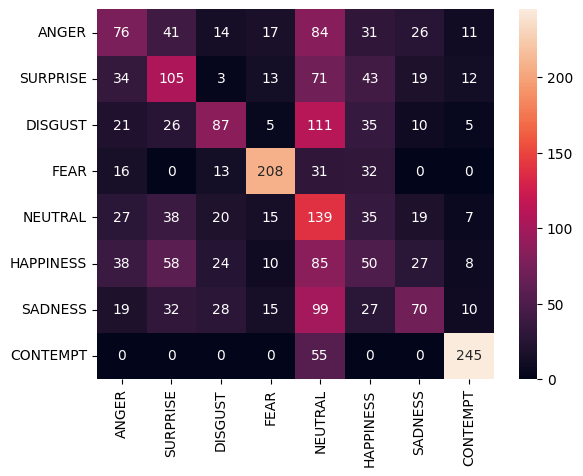

In [175]:
train_run(X_balanced, y_balanced, X_balanced, y_balanced)

In [160]:
# data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train_aug = X_train
y_train_aug = y_train


def augment_minority_class(X_train, y_train, class_id, target_class_size, isMin):
    print(c)

    # Defining the ImageDataGenerator with appropriate augmentation parameters
    if isMin:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,      
            shear_range=0.2,              
            zoom_range=0.2,               
            horizontal_flip=True,         
            fill_mode='nearest'           
        )
    else:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.2,      
            shear_range=0.2,              
            zoom_range=0.1,               
            horizontal_flip=True,         
            fill_mode='nearest'           
        )
    X_class = X_train[y_train == class_id]
    y_class = y_train[y_train == class_id] 
    
    # Create a generator to augment the minority class
    datagen.fit(X_class)
    augmented = datagen.flow(X_class, y_class, batch_size=32, shuffle=False)
    
    X_augmented = []
    y_augmented = []
    
    # Keeping track of the number of images added
    # previous attempt was giving different number of values in X and y
    count = 0
    while count < target_size:
        batch_images, batch_labels = next(augmented)
        remaining = target_size - count
        
        # If the batch exceeds the target size, truncate it
        if len(batch_images) > remaining:
            batch_images = batch_images[:remaining]
            batch_labels = batch_labels[:remaining]
        
        X_augmented.extend(batch_images)
        y_augmented.extend(batch_labels)
        count += len(batch_images)
    
    return np.array(X_augmented), np.array(y_augmented)

# Setting target size for class
minority_class_id = 8
target_size = 3000  

for c in [0,1,2,3,6,7]:
    if c in [3,7]:
        X_augmented, y_augmented = augment_minority_class(X_train, y_train, c, target_size, True)
    else:
        X_augmented, y_augmented = augment_minority_class(X_train, y_train, c, target_size, False)
    X_train_aug = np.concatenate([X_train_aug, X_augmented], axis=0)
    y_train_aug = np.concatenate([y_train_aug, y_augmented], axis=0)


X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)


0
1
2
3
6
7


In [162]:
for ci in np.unique(y_train_aug):
    print(f'{ci}, {classMap[ci]}, {X_train_aug[y_train_aug==ci].shape[0]}')

0, ANGER, 3196
1, SURPRISE, 3270
2, DISGUST, 3152
3, FEAR, 3020
4, NEUTRAL, 5167
5, HAPPINESS, 4245
6, SADNESS, 3212
7, CONTEMPT, 3005


/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1688 - loss: 6.2896
884/884 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

       ANGER       0.23      0.00      0.00      3196
    SURPRISE       0.33      0.00      0.00      3270
     DISGUST       0.56      0.00      0.01      3152
        FEAR       0.30      0.00      0.01      3020
     NEUTRAL       0.18      1.00      0.31      5167
   HAPPINESS       0.07      0.00      0.00      4245
     SADNESS       0.46      0.01      0.02      3212
    CONTEMPT       0.00      0.00      0.00      3005

    accuracy                           0.18     28267
   macro avg       0.27      0.13      0.04     28267
weighted avg       0.25      0.18      0.06     28267



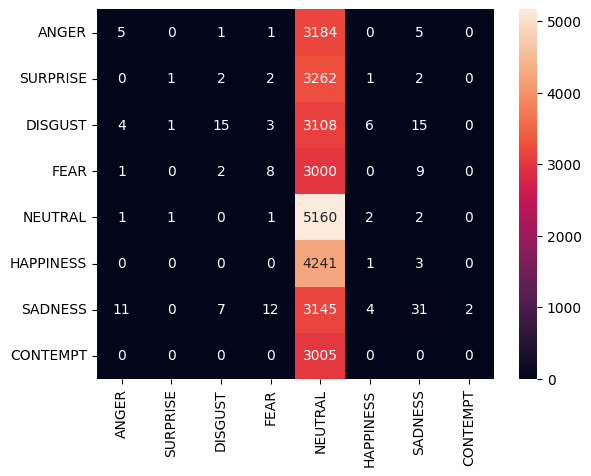

In [174]:
train_run(X_train_aug, y_train_aug, X_train_aug, y_train_aug)

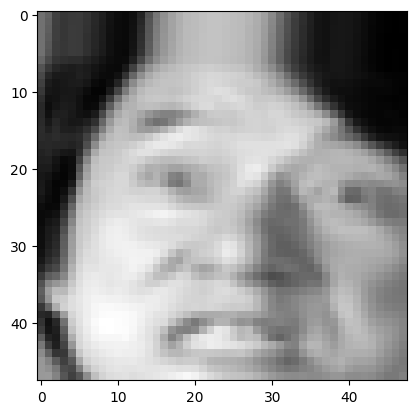

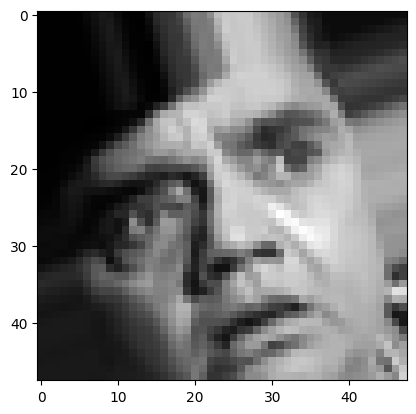

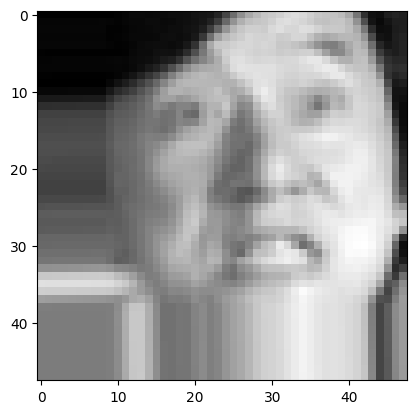

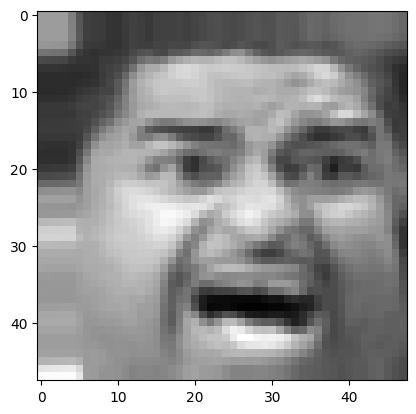

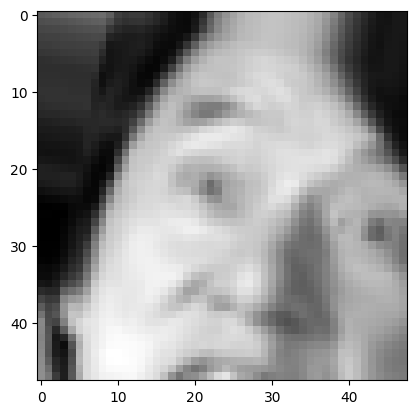

In [165]:
for i in range(5):
    plt.imshow(X_train_aug[np.where(y_train_aug == 3)[0][i]], cmap='gray')
    plt.show()

In [180]:
def train_run(X_tr, y_tr, X_te, y_te, class_weights):
    model = myConvNet()
    model.fit(X_tr, y_tr, class_weight=class_weights)

    y_pred = [y.argmax() for y in model.predict(X_te)]
    #print(y_pred)
    tr_cf_matrix = confusion_matrix(y_te, y_pred)

    labels = [classMap[i] for i in range(0,8)]
    sns.heatmap(tr_cf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

    report = classification_report(y_te, y_pred, target_names=[
    'ANGER', 'SURPRISE', 'DISGUST', 'FEAR', 
    'NEUTRAL', 'HAPPINESS', 'SADNESS', 'CONTEMPT'
    ])
    print(report)

[6.54783163e+00 4.75324074e+00 8.44325658e+00 6.41687500e+01
 2.48379137e-01 3.02326266e-01 6.05365566e+00 2.56675000e+02]


/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3745 - loss: 2.0298
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

       ANGER       0.00      0.00      0.00       196
    SURPRISE       0.00      0.00      0.00       270
     DISGUST       0.60      0.02      0.04       152
        FEAR       0.00      0.00      0.00        20
     NEUTRAL       0.70      0.01      0.02      5167
   HAPPINESS       0.56      0.02      0.03      4245
     SADNESS       0.02      0.97      0.04       212
    CONTEMPT       0.00      0.00      0.00         5

    accuracy                           0.03     10267
   macro avg       0.24      0.13      0.02     10267
weighted avg       0.59      0.03      0.02     10267



/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

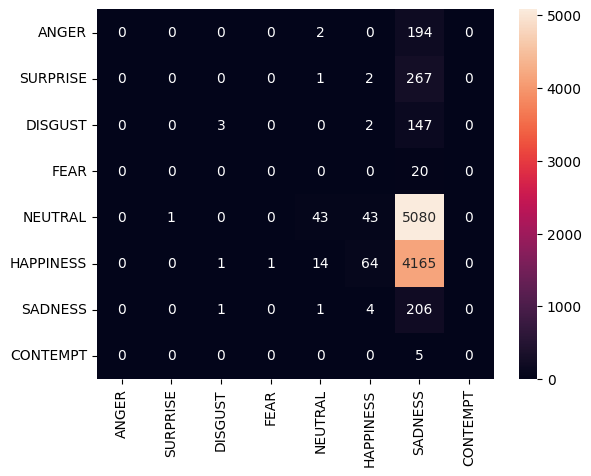

In [185]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
print(class_weights)

train_run(X_train, y_train, X_train, y_train, dict(enumerate(class_weights)))


[1.10556164 1.08054281 1.12099461 1.16999172 0.68383491 0.8323616
 1.10005448 1.17583195]


/Users/heemmanshuu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 46, 46, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 23, 23, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 529)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,450 (134.57 KB)

 Trainable params: 34,450 (134.57 KB)

 Non-trainable params: 0 (0.00 B)

None
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1485 - loss: 2.1424
884/884 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

       ANGER       0.24      0.06      0.10      3196
    SURPRISE       0.24      0.12      0.16      3270
     DISGUST       0.14      0.76      0.24      3152
        FEAR       0.17      0.14      0.15      3020
     NEUTRAL       0.46      0.20      0.28      5167
   HAPPINESS       0.39      0.19      0.26      4245
     SADNESS       0.27      0.04      0.07      3212
    CONTEMPT       0.36      0.22      0.27      3005

    accuracy                           0.21     28267
   macro avg       0.28      0.22      0.19     28267
weighted avg       0.30      0.21      0.20     28267



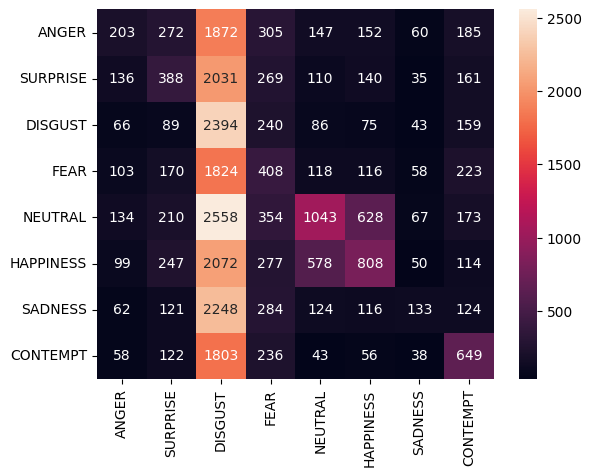

In [187]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_aug),
    y=y_train_aug
)
print(class_weights)

train_run(X_train_aug, y_train_aug, X_train_aug, y_train_aug, dict(enumerate(class_weights)))